In [ ]:
!pip install -q datasets tensorflow scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==

In [ ]:
# Install required packages (only run once if needed)
# !pip install -q datasets tensorflow scikit-learn

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Load SNLI dataset (subset for performance)
snli = load_dataset("snli")
valid_labels = {0: "entailment", 1: "contradiction", 2: "neutral"}

# Filter valid and non-empty entries
data = [
    (p, h, l)
    for p, h, l in zip(snli["train"]["premise"], snli["train"]["hypothesis"], snli["train"]["label"])
    if l in valid_labels and p and h
][:10000]  # Use 10,000 examples for quicker training

premises, hypotheses, labels = zip(*data)

# Tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(premises + hypotheses)

# Convert text to sequences and pad
max_len = 16
premise_seq = tokenizer.texts_to_sequences(premises)
hypothesis_seq = tokenizer.texts_to_sequences(hypotheses)

premise_pad = tf.keras.preprocessing.sequence.pad_sequences(premise_seq, maxlen=max_len, padding='post')
hypothesis_pad = tf.keras.preprocessing.sequence.pad_sequences(hypothesis_seq, maxlen=max_len, padding='post')

# Merge premise and hypothesis
X = np.concatenate([premise_pad, hypothesis_pad], axis=1)  # Shape: (samples, 32)
y = tf.keras.utils.to_categorical(labels, num_classes=3)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build classical NLI model
input_layer = tf.keras.Input(shape=(32,))
x = layers.Embedding(input_dim=5000, output_dim=64)(input_layer)
x = layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(3, activation="softmax")(x)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train
early_stop = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

# Prediction function
def predict_classical(premise, hypothesis):
    p_seq = tokenizer.texts_to_sequences([premise])
    h_seq = tokenizer.texts_to_sequences([hypothesis])
    p_pad = tf.keras.preprocessing.sequence.pad_sequences(p_seq, maxlen=max_len, padding='post')
    h_pad = tf.keras.preprocessing.sequence.pad_sequences(h_seq, maxlen=max_len, padding='post')
    x_input = np.concatenate([p_pad, h_pad], axis=1)

    pred = model.predict(x_input)
    label_map = {0: "Entailment", 1: "Contradiction", 2: "Neutral"}
    label = np.argmax(pred, axis=1)[0]
    confidence = np.max(pred)
    print(f"\nPremise: {premise}")
    print(f"Hypothesis: {hypothesis}")
    print(f"Prediction: {label_map[label]} ({confidence * 100:.2f}%)")

# Try it!
user_premise = input("Enter a premise: ")
user_hypothesis = input("Enter a hypothesis: ")
predict_classical(user_premise, user_hypothesis)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/412k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/413k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/19.6M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/550152 [00:00<?, ? examples/s]

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.4070 - loss: 1.0741 - val_accuracy: 0.3825 - val_loss: 1.0815
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.6031 - loss: 0.8876 - val_accuracy: 0.4595 - val_loss: 1.0133
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.7149 - loss: 0.6934 - val_accuracy: 0.4945 - val_loss: 1.3678
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.7793 - loss: 0.5696 - val_accuracy: 0.5235 - val_loss: 1.1628
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.7997 - loss: 0.4965 - val_accuracy: 0.4660 - val_loss: 1.7611
Enter a premise: All dogs are mammals.
Enter a hypothesis: If a dog is fed a certain type of food, it will gain weight.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step

Premise: All dogs are mammals.
Hypothesis: If a dog is fed a certain type of food, it will gain weight.
Prediction: Contradiction (54.06%)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.7158 - loss: 0.7019 - val_accuracy: 0.5365 - val_loss: 1.0569
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.7773 - loss: 0.5726 - val_accuracy: 0.5000 - val_loss: 1.3548
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8092 - loss: 0.4927 - val_accuracy: 0.4510 - val_loss: 1.5376
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.8346 - loss: 0.4200 - val_accuracy: 0.5115 - val_loss: 1.4641


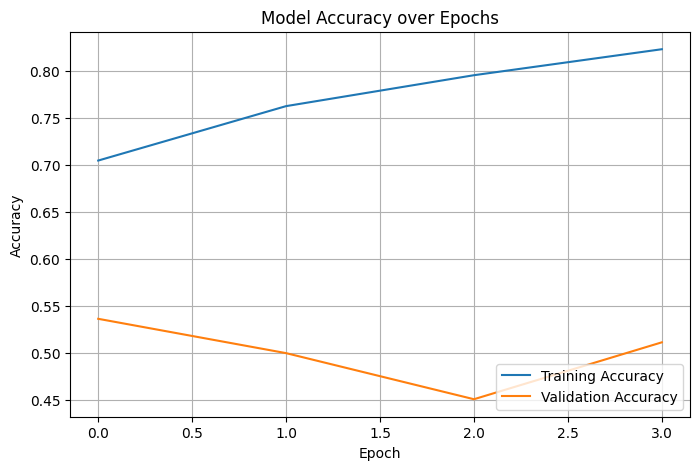

In [ ]:
import matplotlib.pyplot as plt

# Train and capture history
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

# Plot training & validation accuracy values
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.3921 - loss: 1.0810 - val_accuracy: 0.4485 - val_loss: 1.0687
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.6051 - loss: 0.8766 - val_accuracy: 0.4915 - val_loss: 1.0137
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.7158 - loss: 0.7055 - val_accuracy: 0.5265 - val_loss: 1.0614
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.7745 - loss: 0.5700 - val_accuracy: 0.5305 - val_loss: 1.1550
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8030 - loss: 0.4846 - val_accuracy: 0.5040 - val_loss: 1.3715
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

🔵 Classification Report:
               precision    recall  f1-score   support

   Entailment       0.43      0.90      0.58       670
Contradiction       0.64      0.32      0.42       669
      Neutral       0.66      0.25      0.37       661

     accuracy                           0.49      2000
    macr

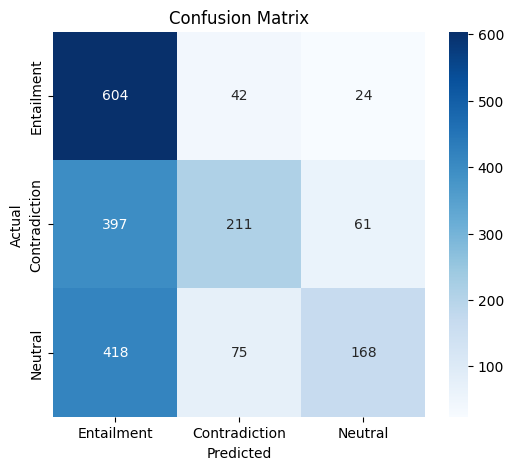

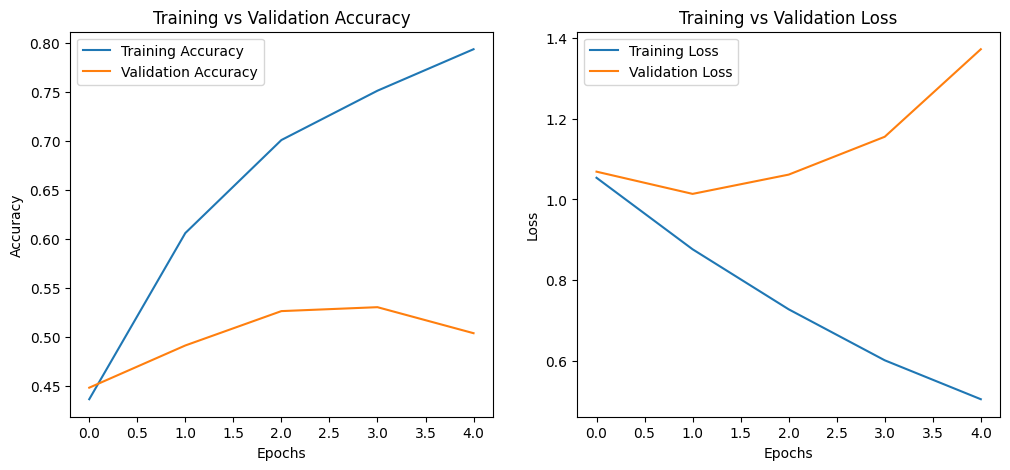


Enter a premise: All dogs are mammals.
Enter a hypothesis: If a dog is fed a certain type of food, it will gain weight.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

📝 Premise: All dogs are mammals.
📝 Hypothesis: If a dog is fed a certain type of food, it will gain weight.
✅ Prediction: Contradiction (55.33%)


In [ ]:
# Install required packages (if not already)
# !pip install -q datasets tensorflow scikit-learn matplotlib seaborn

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load SNLI dataset
snli = load_dataset("snli")
valid_labels = {0: "entailment", 1: "contradiction", 2: "neutral"}

data = [
    (p, h, l)
    for p, h, l in zip(snli["train"]["premise"], snli["train"]["hypothesis"], snli["train"]["label"])
    if l in valid_labels and p and h
][:10000]

premises, hypotheses, labels = zip(*data)

# 2. Tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(premises + hypotheses)

max_len = 16
premise_seq = tokenizer.texts_to_sequences(premises)
hypothesis_seq = tokenizer.texts_to_sequences(hypotheses)

premise_pad = tf.keras.preprocessing.sequence.pad_sequences(premise_seq, maxlen=max_len, padding='post')
hypothesis_pad = tf.keras.preprocessing.sequence.pad_sequences(hypothesis_seq, maxlen=max_len, padding='post')

X = np.concatenate([premise_pad, hypothesis_pad], axis=1)  # (samples, 32)
y = tf.keras.utils.to_categorical(labels, num_classes=3)

# 3. Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Build Model
input_layer = tf.keras.Input(shape=(32,))
x = layers.Embedding(input_dim=5000, output_dim=64)(input_layer)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(3, activation="softmax")(x)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 5. Train Model
early_stop = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

# 6. Evaluate Performance
# Predict on Test Data
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print Classification Report
print("\n🔵 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Entailment", "Contradiction", "Neutral"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Entailment", "Contradiction", "Neutral"],
            yticklabels=["Entailment", "Contradiction", "Neutral"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 7. Plot Accuracy and Loss
# Accuracy Plot
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Loss Plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

# 8. User Input Prediction
def predict_classical(premise, hypothesis):
    p_seq = tokenizer.texts_to_sequences([premise])
    h_seq = tokenizer.texts_to_sequences([hypothesis])
    p_pad = tf.keras.preprocessing.sequence.pad_sequences(p_seq, maxlen=max_len, padding='post')
    h_pad = tf.keras.preprocessing.sequence.pad_sequences(h_seq, maxlen=max_len, padding='post')
    x_input = np.concatenate([p_pad, h_pad], axis=1)

    pred = model.predict(x_input)
    label_map = {0: "Entailment", 1: "Contradiction", 2: "Neutral"}
    label = np.argmax(pred, axis=1)[0]
    confidence = np.max(pred)
    print(f"\n📝 Premise: {premise}")
    print(f"📝 Hypothesis: {hypothesis}")
    print(f"✅ Prediction: {label_map[label]} ({confidence * 100:.2f}%)")

# Run it
user_premise = input("\nEnter a premise: ")
user_hypothesis = input("Enter a hypothesis: ")
predict_classical(user_premise, user_hypothesis)
